In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [18]:
# Load the dataset
dataset = pd.read_csv("spam.csv", encoding='latin1')


In [19]:

# Rename the columns based on inspection
dataset.columns = ['label', 'msg', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']
dataset = dataset[['label', 'msg']]  # Select only the relevant columns


In [20]:
# Map labels to numerical values
dataset['label'] = dataset['label'].map({'ham': 0, 'spam': 1})


In [21]:

# Drop rows with missing values in 'msg'
dataset = dataset.dropna(subset=['msg'])



In [22]:
# Balance the dataset by oversampling the minority class
spam = dataset[dataset['label'] == 1]
ham = dataset[dataset['label'] == 0]
spam_oversampled = spam.sample(len(ham), replace=True, random_state=42)
dataset = pd.concat([ham, spam_oversampled])



In [23]:
# Reset index
dataset = dataset.reset_index(drop=True)


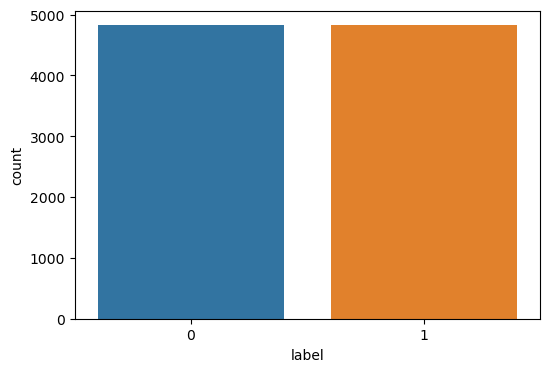

In [24]:
# Visualize the label distribution
plt.figure(figsize=(6, 4))
sns.countplot(x="label", data=dataset)
plt.show()


In [25]:
# Apply word count calculation
dataset['word_count'] = dataset['msg'].apply(lambda x: len(x.split()))



C:\Users\papai\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\papai\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


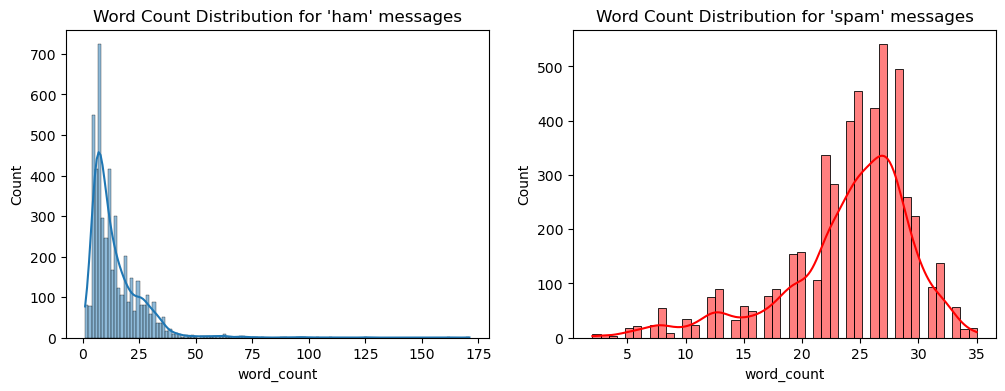

In [26]:
# Visualize word count distribution
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(dataset[dataset["label"] == 0]["word_count"], kde=True)
plt.title("Word Count Distribution for 'ham' messages")
plt.subplot(1, 2, 2)
sns.histplot(dataset[dataset["label"] == 1]["word_count"], color='red', kde=True)
plt.title("Word Count Distribution for 'spam' messages")
plt.show()

In [27]:
# Define currency detection function
def currency(data):
    currency_symbols = ['€', '$', '¥', '£', '₹']
    return int(any(symbol in data for symbol in currency_symbols))

dataset["currency"] = dataset['msg'].apply(currency)



In [28]:
# Define numeric character detection function
def num(data):
    return int(any(char.isdigit() for char in data))

dataset["num"] = dataset['msg'].apply(num)


In [29]:
# Convert 'label', 'currency', and 'num' columns to string type for visualization
dataset["label"] = dataset["label"].astype(str)
dataset["currency"] = dataset["currency"].astype(str)
dataset["num"] = dataset["num"].astype(str)


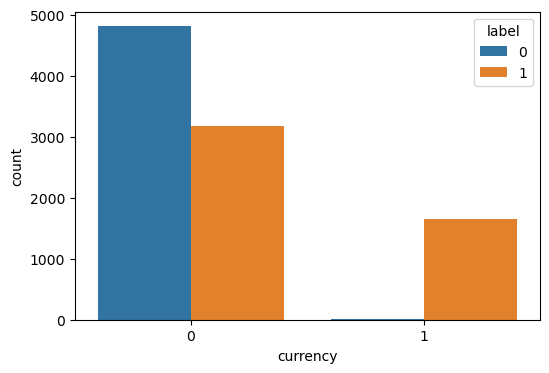

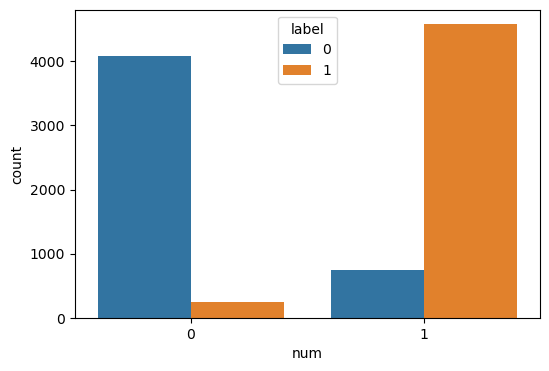

In [30]:
# Visualize currency and numeric features
plt.figure(figsize=(6, 4))
sns.countplot(x="currency", hue="label", data=dataset)
plt.show()

plt.figure(figsize=(6, 4))
sns.countplot(x="num", hue="label", data=dataset)
plt.show()



In [31]:
# Data cleaning and text preprocessing
nltk.download('stopwords')
nltk.download('wordnet')
stopwords = set(nltk.corpus.stopwords.words('english'))
wnl = nltk.stem.WordNetLemmatizer()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\papai\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\papai\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [32]:
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = text.lower()
    words = text.split()
    filtered_words = [word for word in words if word not in stopwords]
    lemmatized_words = [wnl.lemmatize(word) for word in filtered_words]
    return ' '.join(lemmatized_words)

dataset['clean_msg'] = dataset['msg'].apply(preprocess_text)


In [33]:
# Transform text data to TF-IDF features
tfidf = TfidfVectorizer(max_features=500)
vectors = tfidf.fit_transform(dataset['clean_msg']).toarray()


In [34]:
# Prepare feature and target variables
X = pd.DataFrame(vectors)
y = dataset['label'].astype(int)

In [35]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [36]:
# Train the model
mnb = MultinomialNB()
mnb.fit(X_train, y_train)


MultinomialNB()

In [37]:
# Evaluate the model
y_pred = mnb.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.95      0.89      0.92      1238
           1       0.89      0.95      0.92      1174

    accuracy                           0.92      2412
   macro avg       0.92      0.92      0.92      2412
weighted avg       0.92      0.92      0.92      2412

[[1097  141]
 [  60 1114]]
Accuracy: 0.9166666666666666


In [38]:
# Define the predict_spam function
def predict_spam(sms):
    message = preprocess_text(sms)
    temp = tfidf.transform([message]).toarray()
    return mnb.predict(temp)


In [39]:
# Prediction example
sample_message = "As a valued customer, I am pleased to advise you that following recent review of your Mob No. you are awarded with a å£1500 Bonus Prize, call 09066364589"
if predict_spam(sample_message):
    print('Gotcha! This is a SPAM message.')
else:
    print('This is a HAM (normal) message.')


Gotcha! This is a SPAM message.


In [42]:
# Prediction example 2
sample_message = "K tell me anything about you."
if predict_spam(sample_message):
    print('Gotcha! This is a SPAM message.')
else:
    print('This is a HAM (normal) message.')


This is a HAM (normal) message.
